## Setup

In [1]:
import os
import json
import glob
import torch
import re
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
#import seaborn as sns
import matplotlib.pyplot as plt
from utils.data_processing import (
    load_edge_scores_into_dictionary,
    read_json_file,
    get_ckpts,
    load_metrics,
    compute_ged,
    compute_weighted_ged,
    compute_gtd,
    compute_jaccard_similarity_to_reference,
    compute_jaccard_similarity,
    compute_weighted_jaccard_similarity,
    compute_weighted_jaccard_similarity_to_reference,
    aggregate_metrics_to_tensors_step_number,
    get_ckpts
)

In [3]:
# =============================================================================
#import kaleido
#pio.renderers.default = 'png' # USE IF MAKING GRAPHS FOR NOTEBOOK EXPORT
# =============================================================================

In [7]:
TASK = 'ioi'
PERFORMANCE_METRIC = 'logit_diff'
MODEL_NAME = 'pythia-160m-alldropout'

## Retrieve & Process Data

### Circuit Data

In [5]:
folder_path = f'results/graphs/{MODEL_NAME}/{TASK}'
df = load_edge_scores_into_dictionary(folder_path)

Processing file 1/143: results/graphs/pythia-160m-alldropout/ioi/57000.json
Processing file 2/143: results/graphs/pythia-160m-alldropout/ioi/141000.json
Processing file 3/143: results/graphs/pythia-160m-alldropout/ioi/95000.json
Processing file 4/143: results/graphs/pythia-160m-alldropout/ioi/107000.json
Processing file 5/143: results/graphs/pythia-160m-alldropout/ioi/34000.json
Processing file 6/143: results/graphs/pythia-160m-alldropout/ioi/6000.json
Processing file 7/143: results/graphs/pythia-160m-alldropout/ioi/37000.json
Processing file 8/143: results/graphs/pythia-160m-alldropout/ioi/39000.json
Processing file 9/143: results/graphs/pythia-160m-alldropout/ioi/104000.json
Processing file 10/143: results/graphs/pythia-160m-alldropout/ioi/59000.json
Processing file 11/143: results/graphs/pythia-160m-alldropout/ioi/67000.json
Processing file 12/143: results/graphs/pythia-160m-alldropout/ioi/111000.json
Processing file 13/143: results/graphs/pythia-160m-alldropout/ioi/76000.json
Proce

### Performance Data

In [8]:
#with open('results/baselines/pythia-160m-hiddendropout/ioi.json') as f:
    #perf_metrics = json.load(f)
perf_metrics = torch.load(f'results/backup/{MODEL_NAME}/nmh_backup_metrics.pt')

In [9]:
perf_metrics.keys()

dict_keys([4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000, 101000, 102000, 103000, 104000, 105000, 106000, 107000, 108000, 109000, 110000, 111000, 112000, 113000, 114000, 115000, 116000, 117000, 118000, 119000, 120000, 121000, 122000, 123000, 124000, 125000, 126000, 127000, 128000, 129000, 130000, 131000, 132000, 133000, 134000, 135000, 136000, 137000, 138000, 139000, 140

In [10]:
# directory_path = 'results'
# perf_metrics = load_metrics(directory_path)

# ckpts = get_ckpts(schedule="exp_plus_detail")
# #pythia_evals = aggregate_metrics_to_tensors_step_number("results/pythia-evals/pythia-v1")

# filter everything before 1000 steps
df = df[df['checkpoint'] >= 4000]

In [11]:
#perf_metric = perf_metrics['pythia-160m-hiddendropout'][TASK][PERFORMANCE_METRIC]

#perf_metric = [x.item() for x in perf_metric]

# zip into dictionary with ckpts as key
#perf_metric_dict = dict(zip(ckpts, perf_metric))

perf_metric_dict = {checkpoint: perf_metrics[checkpoint]['logit_diff'] for checkpoint in perf_metrics.keys()}


## Visualize Results

### Graph Size

In [12]:
# Summarize the total number of edges in the graph at each checkpoint, filtered by in_circuit
subgraph_df = df[df['in_circuit'] == True]

# Group by checkpoint and sum the number of edges
subgraph_df = subgraph_df.groupby('checkpoint').size().reset_index(name='num_edges')

subgraph_df.head()


,checkpoint,num_edges
0,4000,47
1,5000,8
2,6000,50
3,7000,78
4,8000,57


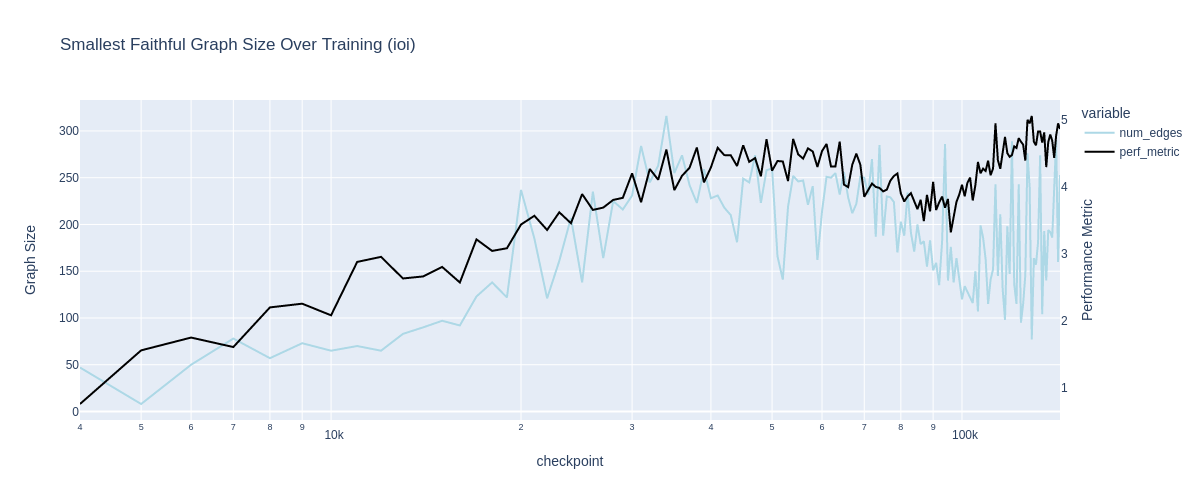

In [13]:
# Plot the number of edges in the subgraph at each checkpoint, along with performance metrics

# Add a new column for the performance metric by mapping the checkpoint values using the perf_metric_dict
subgraph_df['perf_metric'] = subgraph_df['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
subgraph_df['perf_metric'] = subgraph_df['perf_metric'].interpolate(method='linear')

# Plot the number of edges in the subgraph at each checkpoint
fig = px.line(subgraph_df, x='checkpoint', y=['num_edges'], title=f'Smallest Faithful Graph Size Over Training ({TASK})', log_x=True, width=1200)

# Specify colors for each line
colors = {'num_edges': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Performance Metric", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=subgraph_df['checkpoint'], y=subgraph_df['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Graph Size"
)

fig.show()


In [22]:
df.head()

,edge,score,in_circuit,checkpoint
16172,m4->a8.h1<q>,-1.311302e-05,False,1000
10775,a0.h10->a7.h2<v>,6.183982e-07,False,1000
10776,a0.h10->a7.h3<q>,-2.607703e-07,False,1000
10777,a0.h10->a7.h3<k>,-3.799796e-07,False,1000
10778,a0.h10->a7.h3<v>,1.952052e-06,False,1000


### Graph Transformations

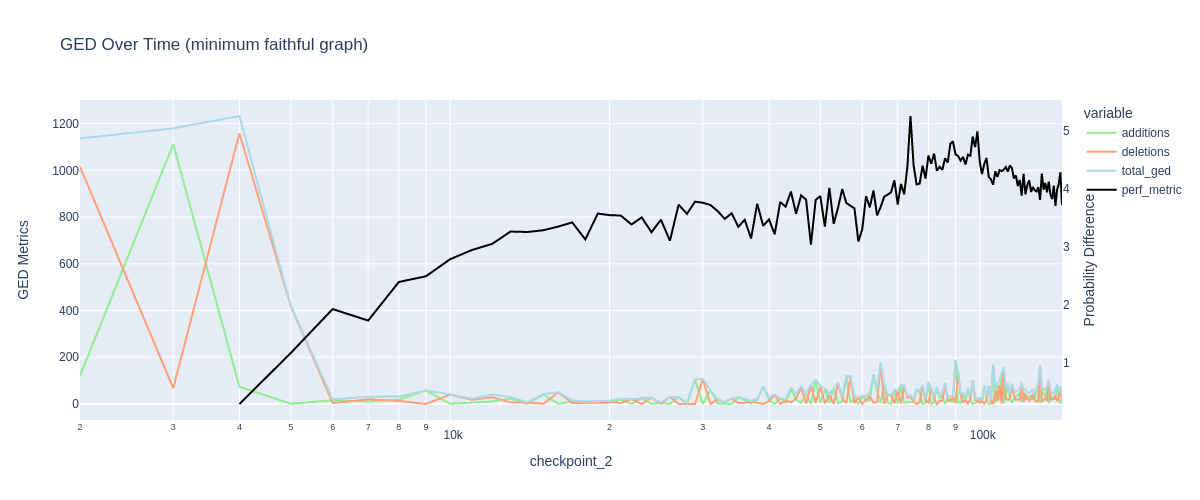

In [23]:
# Assuming ged_results is a DataFrame and compute_ged is a function that returns a DataFrame
ged_results = compute_ged(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
ged_results['perf_metric'] = ged_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
ged_results['perf_metric'] = ged_results['perf_metric'].interpolate(method='linear')

# Plotting as before
fig = px.line(ged_results, x='checkpoint_2', y=['additions', 'deletions', 'total_ged'], title='GED Over Time (minimum faithful graph)', width=1200, log_x=True)

# Specify colors for each line and update trace colors
colors = {'additions': 'lightgreen', 'deletions': 'lightsalmon', 'total_ged': 'lightblue', 'perf_metric': 'black'}
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))

# Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=ged_results['checkpoint_2'], y=ged_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout for titles or other aesthetics
fig.update_layout(yaxis_title="GED Metrics")
fig.show()

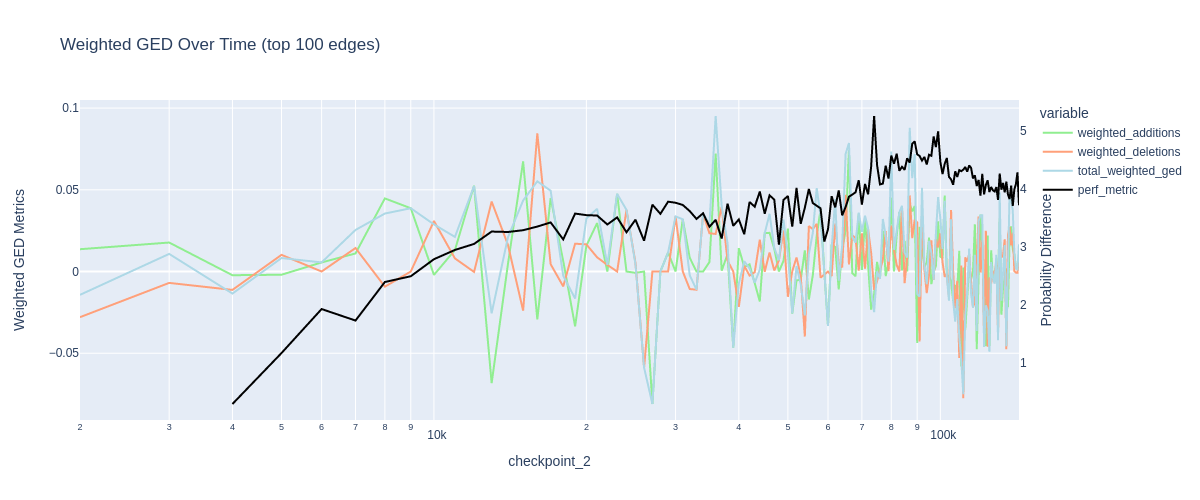

In [25]:
weighted_ged_results = compute_weighted_ged(df)
# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
weighted_ged_results['perf_metric'] = weighted_ged_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
weighted_ged_results['perf_metric'] = weighted_ged_results['perf_metric'].interpolate(method='linear')

# plot weighted additions, deletions, and total weighted GED over time
fig = px.line(weighted_ged_results, width=1200, x='checkpoint_2', y=['weighted_additions', 'weighted_deletions', 'total_weighted_ged'], title='Weighted GED Over Time (top 100 edges)', log_x=True)

# Specify colors for each line
colors = {'weighted_additions': 'lightgreen', 'weighted_deletions': 'lightsalmon', 'total_weighted_ged': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


# Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=weighted_ged_results['checkpoint_2'], y=weighted_ged_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Weighted GED Metrics"
)

fig.show()

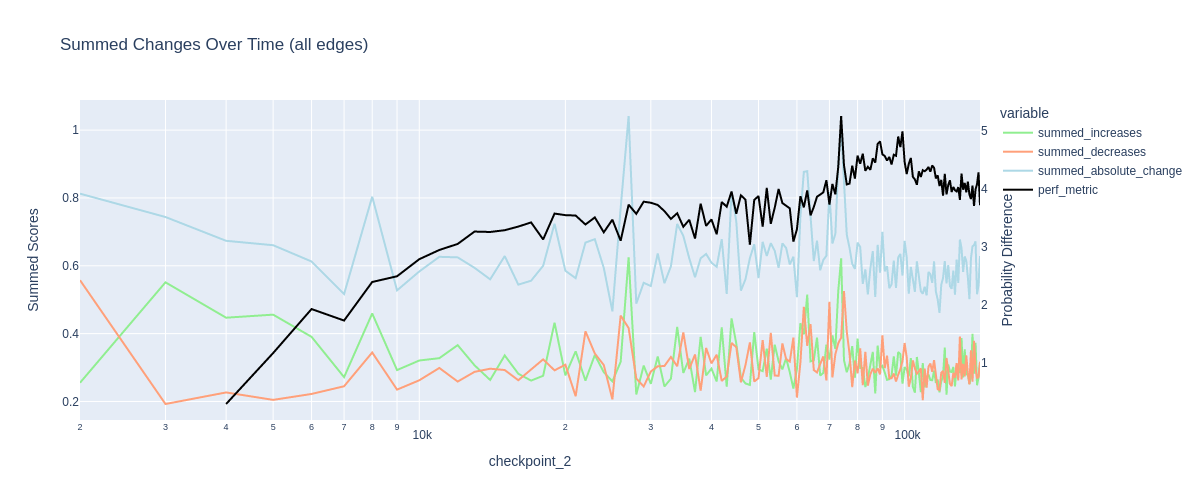

In [26]:
gtd_results = compute_gtd(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
gtd_results['perf_metric'] = gtd_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
gtd_results['perf_metric'] = gtd_results['perf_metric'].interpolate(method='linear')

# plot weighted additions, deletions, and total weighted GTD over time
fig = px.line(gtd_results, width=1200, x='checkpoint_2', y=['summed_increases', 'summed_decreases', 'summed_absolute_change'], title='Summed Changes Over Time (all edges)', log_x=True)

# Specify colors for each line
colors = {'summed_increases': 'lightgreen', 'summed_decreases': 'lightsalmon', 'summed_absolute_change': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


# Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=gtd_results['checkpoint_2'], y=gtd_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Summed Scores"
)

fig.show()

### Graph Similarity

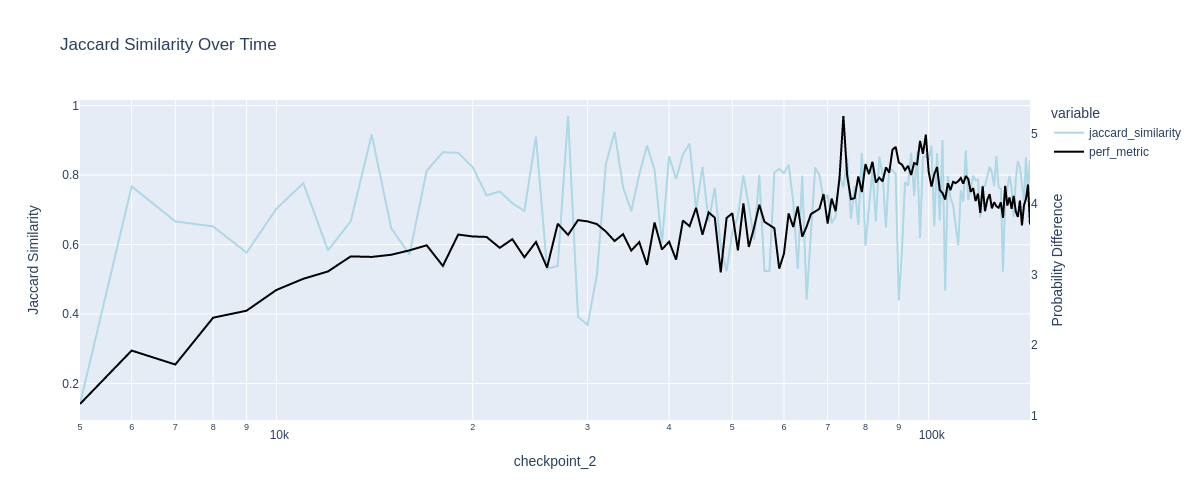

In [46]:
jaccard_results = compute_jaccard_similarity(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_results['perf_metric'] = jaccard_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
jaccard_results['perf_metric'] = jaccard_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_results, width=1200, x='checkpoint_2', y=['jaccard_similarity'], title='Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_results['checkpoint_2'], y=jaccard_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Jaccard Similarity"
)

fig.show()

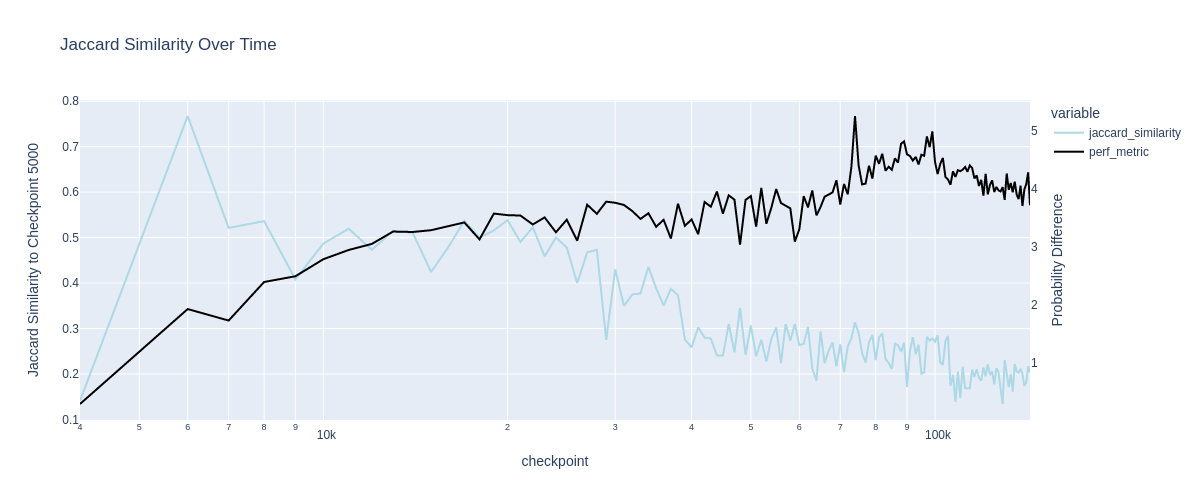

In [47]:
comparison_checkpoint = 5000

jaccard_reference_results = compute_jaccard_similarity_to_reference(df, comparison_checkpoint)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_reference_results['perf_metric'] = jaccard_reference_results['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
jaccard_reference_results['perf_metric'] = jaccard_reference_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_reference_results, width=1200, x='checkpoint', y=['jaccard_similarity'], title='Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_reference_results['checkpoint'], y=jaccard_reference_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title=f"Jaccard Similarity to Checkpoint {comparison_checkpoint}"
)

fig.show()

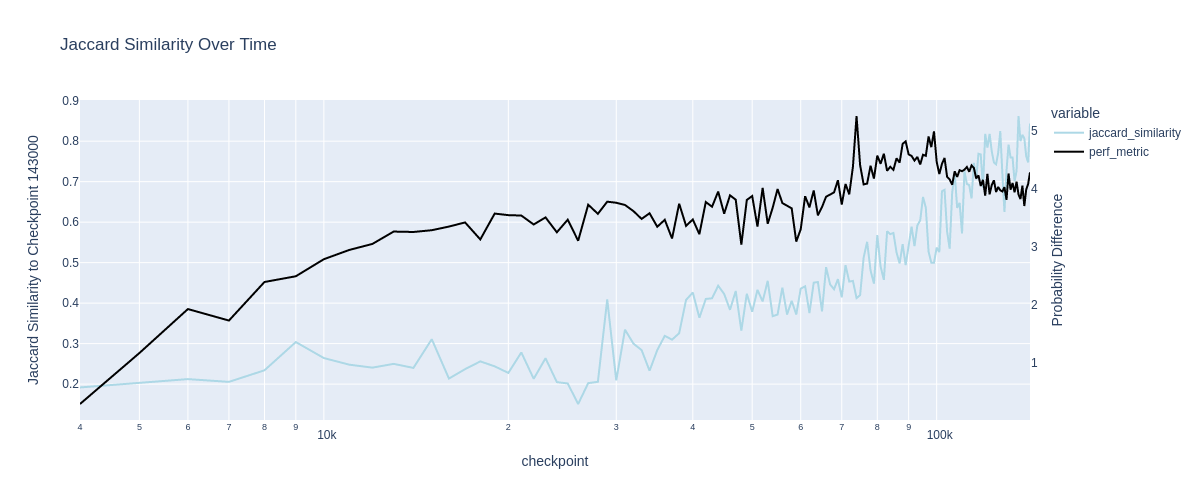

In [48]:
comparison_checkpoint = 143000

jaccard_reference_results = compute_jaccard_similarity_to_reference(df, comparison_checkpoint)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_reference_results['perf_metric'] = jaccard_reference_results['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
jaccard_reference_results['perf_metric'] = jaccard_reference_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_reference_results, width=1200, x='checkpoint', y=['jaccard_similarity'], title='Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_reference_results['checkpoint'], y=jaccard_reference_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title=f"Jaccard Similarity to Checkpoint {comparison_checkpoint}"
)

fig.show()

In [ ]:
def plot_graph_metric(df, metric, title, log_x=True):
    # Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
    df['perf_metric'] = df['checkpoint_2'].map(perf_metric_dict)

    # Interpolate missing values
    df['perf_metric'] = df['perf_metric'].interpolate(method='linear')

    # plot weighted additions, deletions, and total weighted GED over time
    fig = px.line(df, width=1200, x='checkpoint_2', y=[metric], title=title, log_x=log_x)

    # Specify colors for each line
    colors = {metric: 'lightblue', 'perf_metric': 'black'}

    # Update each trace with the specified color
    for i, trace in enumerate(fig.data):
        fig.data[i].update(line=dict(color=colors[trace.name]))


    # Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
    fig.update_layout(
        yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
    )
    fig.add_trace(
        go.Scatter(x=df['checkpoint_2'], y=df['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
    )

    # Optional: Update the layout if you need to adjust titles or other aesthetics
    fig.update_layout(
        yaxis_title=title
    )

    fig.show()

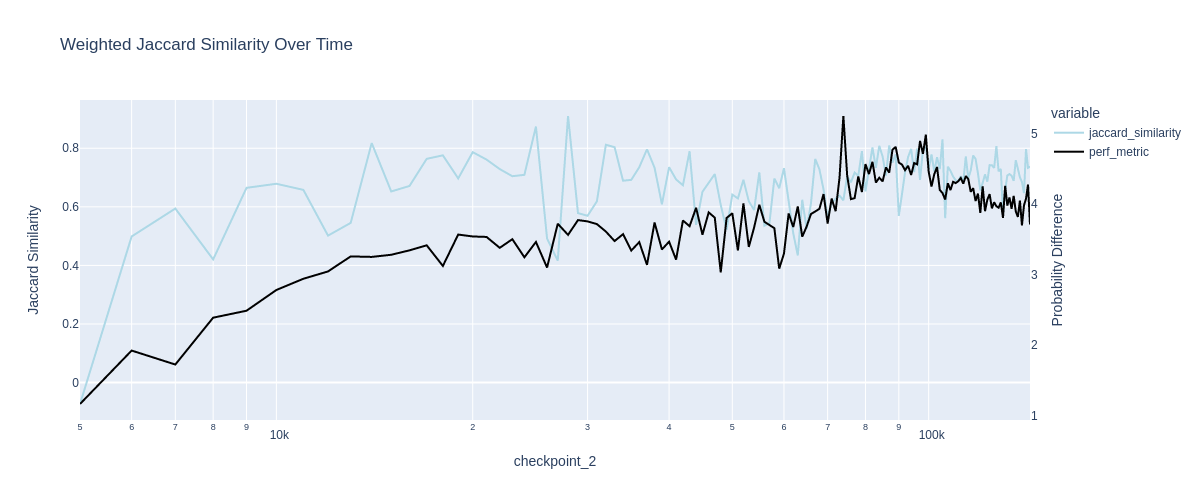

In [51]:
weighted_jaccard_results = compute_weighted_jaccard_similarity(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
weighted_jaccard_results['perf_metric'] = weighted_jaccard_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
weighted_jaccard_results['perf_metric'] = weighted_jaccard_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(weighted_jaccard_results, width=1200, x='checkpoint_2', y=['jaccard_similarity'], title='Weighted Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=weighted_jaccard_results['checkpoint_2'], y=weighted_jaccard_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Jaccard Similarity"
)

fig.show()

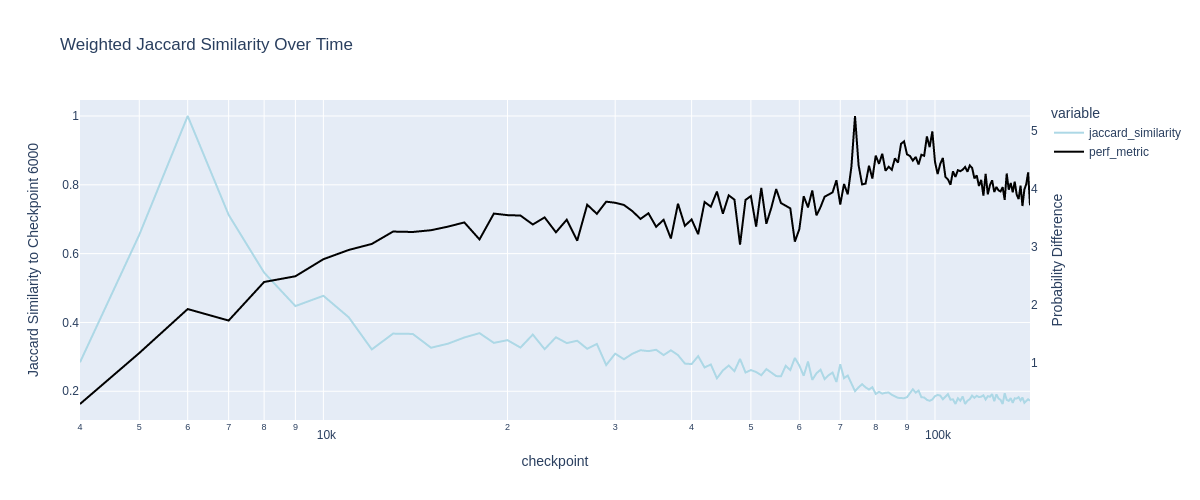

In [62]:
comparison_checkpoint = 6000

jaccard_reference_results = compute_weighted_jaccard_similarity_to_reference(df, comparison_checkpoint)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_reference_results['perf_metric'] = jaccard_reference_results['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
jaccard_reference_results['perf_metric'] = jaccard_reference_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_reference_results, width=1200, x='checkpoint', y=['jaccard_similarity'], title='Weighted Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_reference_results['checkpoint'], y=jaccard_reference_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title=f"Jaccard Similarity to Checkpoint {comparison_checkpoint}"
)

fig.show()

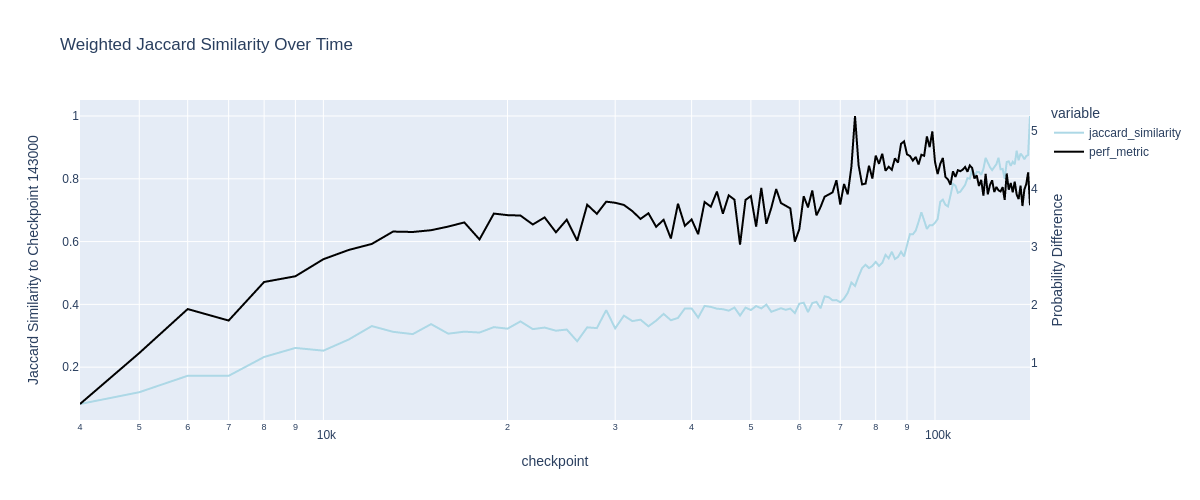

In [63]:
comparison_checkpoint = 143000

jaccard_reference_results = compute_weighted_jaccard_similarity_to_reference(df, comparison_checkpoint)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_reference_results['perf_metric'] = jaccard_reference_results['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
jaccard_reference_results['perf_metric'] = jaccard_reference_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_reference_results, width=1200, x='checkpoint', y=['jaccard_similarity'], title='Weighted Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_reference_results['checkpoint'], y=jaccard_reference_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title=f"Jaccard Similarity to Checkpoint {comparison_checkpoint}"
)

fig.show()

In [39]:
jaccard_results

,checkpoint_1,checkpoint_2,jaccard_similarity,perf_metric
0,1000,2000,0.264554,NaN
1,2000,3000,0.281364,NaN
2,3000,4000,0.251820,0.288510
3,4000,5000,0.140816,1.165822
4,5000,6000,0.767442,1.922970
...,...,...,...,...
137,138000,139000,0.770909,3.696525
138,139000,140000,0.724026,3.981366
139,140000,141000,0.850932,4.073897
140,141000,142000,0.748344,4.275508


In [40]:
jaccard_reference_results

,reference_checkpoint,checkpoint,jaccard_similarity,perf_metric
0,143000,1000,0.056760,NaN
1,143000,2000,0.097983,NaN
2,143000,3000,0.077566,NaN
3,143000,4000,0.191736,0.288510
4,143000,5000,0.203187,1.165822
...,...,...,...,...
137,143000,138000,0.815789,4.048747
138,143000,139000,0.806950,3.696525
139,143000,140000,0.762542,3.981366
140,143000,141000,0.747541,4.073897
